## Проба методов сегментации
### Kaggle Denoising Dirty Documents
#### Севастопольский Артем

In [14]:
import os
import glob
import cv2
import bisect
from math import sqrt
import numpy as np
import pandas as pd
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import skimage
import skimage.segmentation
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
from numba import jit
# my library that deals with images and this data set specifically:
from imhandle import load_image, save_image, show_image, rmse, load_set

Над изображениями уже была сделан первый этап обработки. Она заключалась в том, что для каждого изображения:
* была сделана его свёртка с медианным фильтром,
* от изображения были оставлены только пиксели, яркость которых выше, чем в этой свёртке.

Таким образом, были получены бинаризованные изображения - изображения с цветами только 0 и 1. Эти изображения сохранены в папках output_for_train и output_for_test.

Здесь пытаюсь улучшить результаты первого этапа обработки.

Загрузим файлы исходной обучающей выборки, обучающей выборки после очистки медианным фильтром (лежат в папках output_for_train и output_for_test) и ответов.

In [2]:
# original data
X_train_orig, X_train_orig_files = load_set('../train')    # we can set shuffle=True
X_test_orig, X_test_orig_files = load_set('../test')
# after processing - will be used as train
X_train, X_train_files = load_set('../output_for_train')
# answers
y_train, y_train_files = load_set('../train_cleaned') 
# test
X_test, X_test_files = load_set('../output_for_test')

Произвольная картинка:

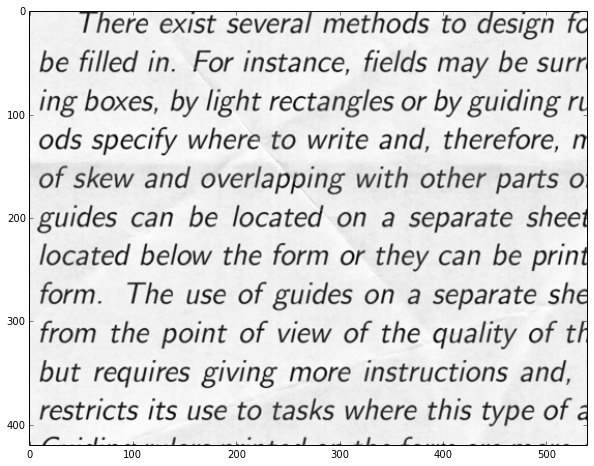

In [3]:
show_image(X_train_orig[0], fig_size=(10, 10))

In [135]:
print "# of Train samples: ", len(X_train)
print "Train sizes: ", map(lambda el: el.shape, X_train)
print "# of Test samples: ", len(X_test)
print "Test sizes: ", map(lambda el: el.shape, X_test)

# of Train samples:  144
Train sizes:  [(420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (258, 540), (258, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), (420, 540), 

### Обзор разных методов сегментации изображений.

#### Требование к методу: каждая буква должна быть одной связной компонентой. Плюс, желательно, чтобы компонента не "расползлась" на другие пиксели.

**Метод Quickshift**. Работает с цветными изображениями, поэтому черно-белый сначала преобразуется в цветной функцией *gray_to_color* (на каждый канал копируются значения цветов исходной черно-белой картинки). С параметром ratio=1 осуществляет классификацию, основываясь только на положении пикселей, не на цвете.

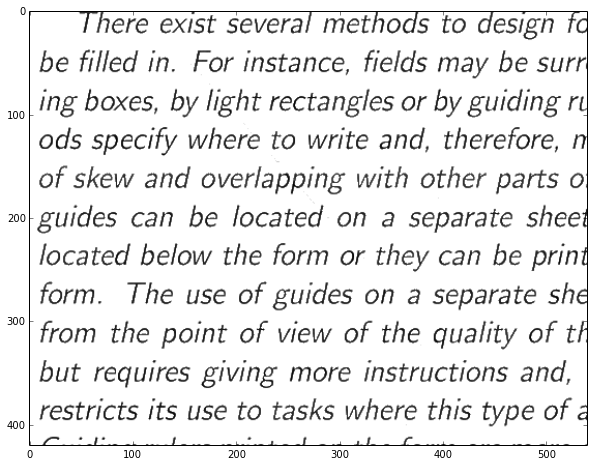

In [9]:
show_image(X_train[0])

In [76]:
def gray_to_color(img):
    '''Simply converting (w, h) 2D array to (w, h, 3) 3D array.'''
    img_3d = np.empty((img.shape[0], img.shape[1], 3))
    for k in xrange(3):
        img_3d[:, :, k] = img.copy()
    return img_3d

qs = skimage.segmentation.quickshift(gray_to_color(X_train[0]), 
                                     ratio=1, kernel_size=5, 
                                     sigma=0, random_seed=243)
qs_max = qs.max()
qs_img = qs / float(qs_max)

[[49 49 49 ..., 49 49 49]
 [49 49 49 ..., 49 49 49]
 [49 49 49 ..., 49 49 49]
 ..., 
 [49 49 49 ..., 49 49 49]
 [49 49 49 ..., 49 49 49]
 [49 49 49 ..., 49 49 49]]


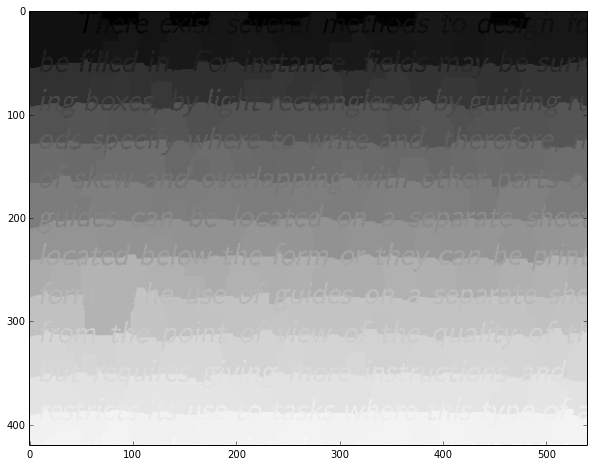

In [11]:
show_image(qs_img, fig_size=(10, 10))
#print np.unique(qs)
#print np.all(np.unique(qs) == np.arange(qs_max))
print qs[:40, :40]

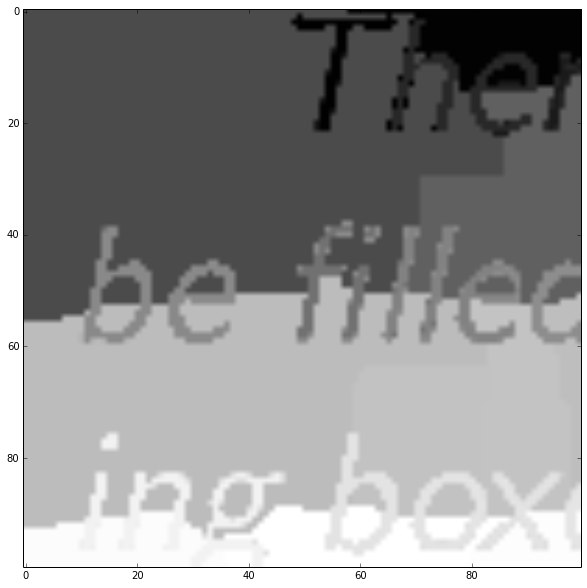

In [9]:
show_image(qs_img[:100, :100])

In [10]:
#show_image(qs_img[:150, :150])

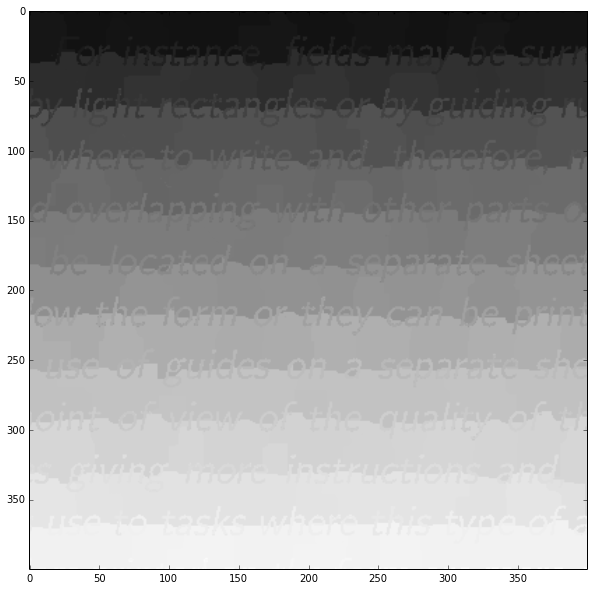

In [11]:
show_image(qs_img[-400:, -400:])

**Метод Felzenszwalb.** Быстрый метод, основанный на графах.

In [5]:
fzw = skimage.segmentation.felzenszwalb(X_train[0], scale=10000, 
                                        sigma=0.15, min_size=5)
#fzw = skimage.segmentation.join_segmentations(fzw, qs)
fzw_max = fzw.max()
fzw_img = fzw / float(fzw_max)

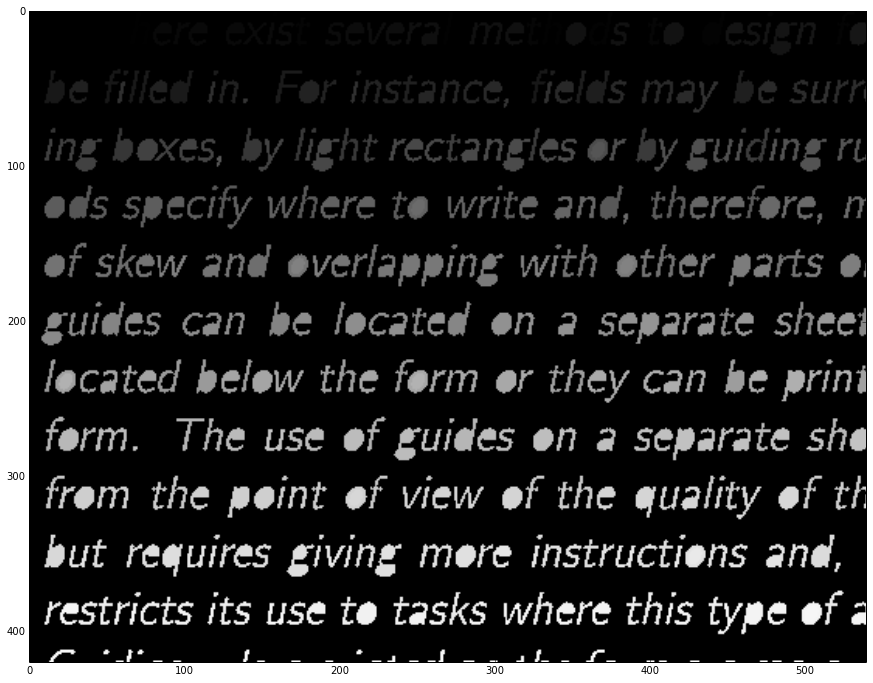

In [6]:
show_image(fzw_img, fig_size=(15, 15))

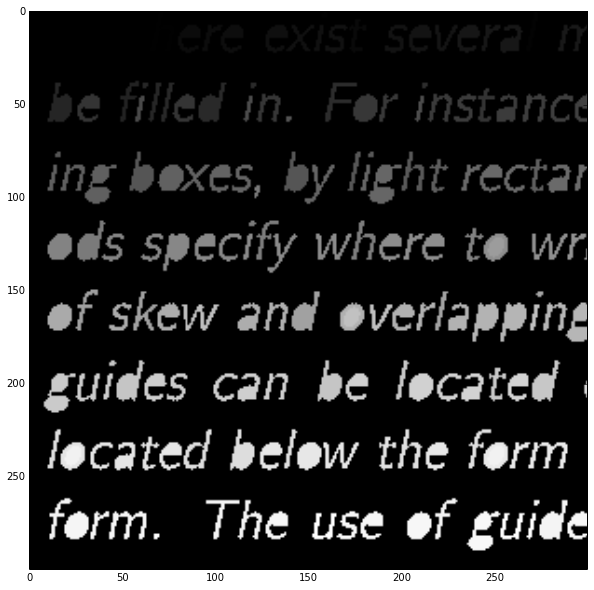

In [7]:
show_image(fzw_img[:300, :300])

Еще в библиотеке skimage есть методы random walker, watershed. Они вряд ли применимы здесь. Есть функция join_segmentations, оставляющая только те пиксели, которые принадлежит одной компоненте в первой сегментации и во второй.

Метод Felzenswalb достаточно хорошо выделяет буквы. Иногда он закрашивает буквы, в которых есть внутренности; ниже описано, как с этим можно бороться.

### Попробуем оставить на изображении только компоненты, которые находит метод Felzenswalb (все, кроме фона).
При этом будем не просто оставлять их, а заменять цветами исходного изображения.

In [5]:
#@jit
def leave_segments(orig, mask, segments, replace=None):
    '''Leaves only specific segments in image.
    orig: original image
    mask: segmentation mask
    segments: list (or numpy vector) of segment numbers to leave in image.
    replace: what to replace components with. 
    If None, replace=orig.
    Returns: image with only left segments. Removed segments are blanked.
    '''
    
    if replace is None:
        replace = orig
    
    segments_sorted = np.array(segments)
    segments_sorted.sort()
    new = replace.copy()
    for i in xrange(new.shape[0]):
        for j in xrange(new.shape[1]):
            pos = bisect.bisect_left(segments_sorted, mask[i, j])
            if pos == len(segments_sorted) or segments_sorted[pos] != mask[i, j]:
                new[i, j] = 1.0
    return new  

In [140]:
img_idx = 1

#scale=10, sigma=0.25, min_size=5
fzw = skimage.segmentation.felzenszwalb(X_train[img_idx], scale=10000, 
                                        sigma=0.15, min_size=5)
segments_to_leave = np.unique(fzw)
segments_to_leave = segments_to_leave[segments_to_leave != 0]
blanked = leave_segments(X_train[img_idx], fzw, segments_to_leave, X_train_orig[img_idx])
print "error for train image: ", rmse(y_train[img_idx], X_train[img_idx])
print "error for train image: ", rmse(y_train[img_idx], blanked)

error for train image:  0.0760900710681
error for train image:  0.0744585434394


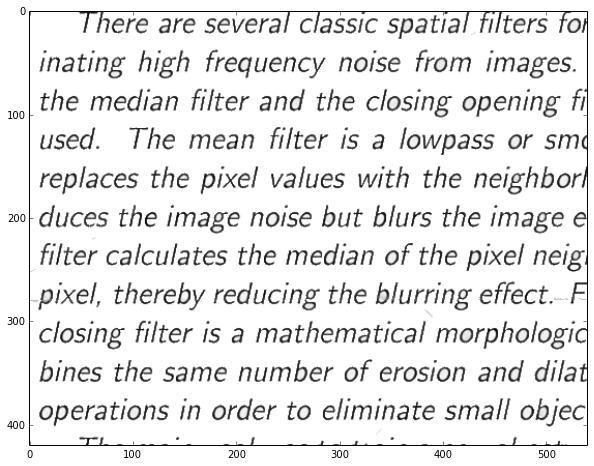

In [141]:
show_image(blanked, fig_size=(10, 10))
#plt.hist(blanked.ravel(), bins=100)

Видно, что внутренности букв ("о", "d") остаются закрашенными. Кроме того, на изображении есть дефекты - серые полоски.

1. Найдем контуры изображения (функцией из библиотеки skimage), получим изображение контуров. Теперь применим сегментацию Felzenszwalb не к исходному изображению, а к изображению контуров. Так внутренности букв станут отдельными компонентами.
2. Оставим только компоненты, у которых есть пиксели, граничащие с фоном.
3. Рассчитаем средний цвет всех компонент. Уберем компоненты, средних цвет которых сильно отличается от среднего цвета по всем буквам.

error for train image:  0.0747538307414
error for train image:  0.0598459978392


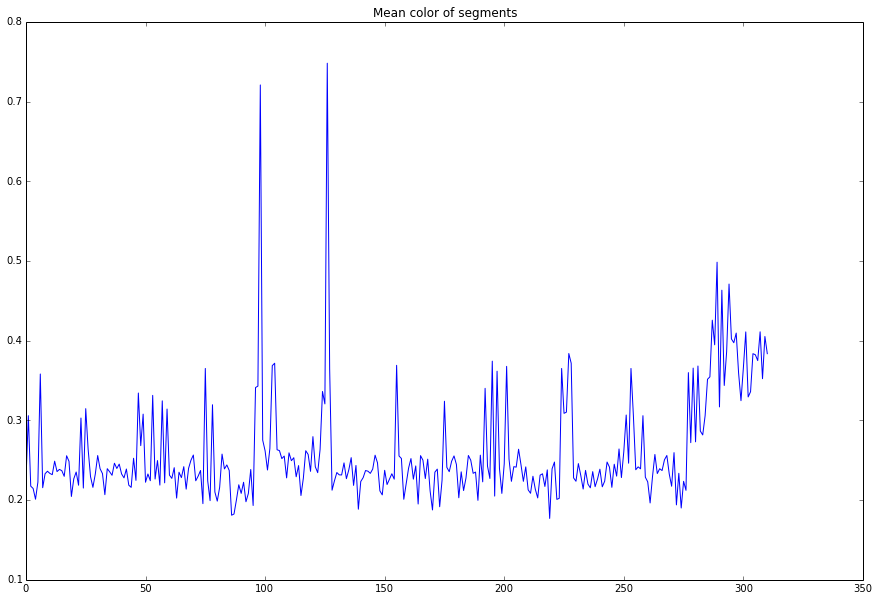

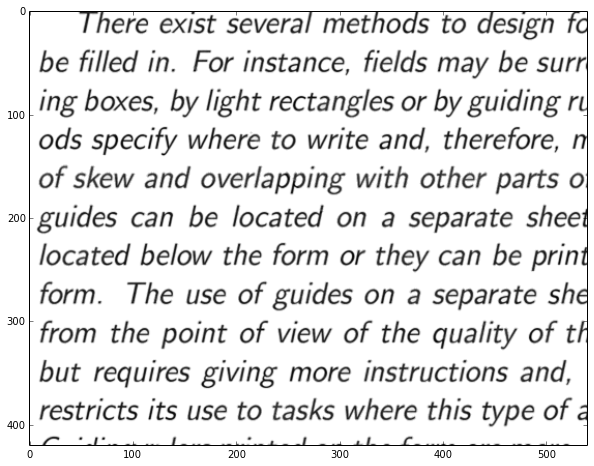

In [169]:
@jit
def near_background(mask):
    segments = []
    neighbors = 8
    background = 0
    di = np.array([-1, 0, 1, 1, 1, 0, -1, -1])
    dj = np.array([1, 1, 1, 0, -1, -1, -1, 0])
    width, height = mask.shape

    for i in xrange(width):
        for j in xrange(height):
            if mask[i, j] == background:
                continue
            for k in xrange(neighbors):
                new_i = i + di[k]
                new_j = j + dj[k]
                if 0 <= new_i < width and 0 <= new_j < height and mask[new_i, new_j] == background:
                    segments.append(mask[i, j])
                    break
    return np.unique(np.array(segments))


def blank_by_edges_and_fzw(img, img_orig, plot_segm_mean=False):
    edges = skimage.segmentation.boundaries.find_boundaries(img).astype(float)
    #show_image(edges, fig_size=(20, 20))
    edges_fzw = skimage.segmentation.felzenszwalb(edges, scale=1000, sigma=0.15, min_size=10)
    edges_fzw_max = edges_fzw.max()
    edges_fzw_img = edges_fzw / float(edges_fzw_max)
    #show_image(edges_fzw_img)

    '''
    # leaving only segments that lie on boundary
    segments_to_leave = edges_fzw[edges.astype(bool)]
    '''
    # leaving only segments that lie near background
    segments_to_leave_1 = near_background(edges_fzw)
    
    # Leaving only segments that have mean color very different from letters mean color
    selected = np.full_like(edges_fzw, False, dtype=bool)
    segm_mean = []
    for segm in segments_to_leave_1:
        selected |= (edges_fzw == segm)
        segm_mean.append(img[(edges_fzw == segm) & (img < 0.95)].mean())
    if plot_segm_mean:
        plt.figure(figsize=(15, 10))
        plt.title("Mean color of segments")
        plt.plot(segm_mean)
    all_mean = img[selected & (img < 0.95)].mean()
    all_var = img[selected & (img < 0.95)].var()
    #print all_mean, all_var
    #all_mean = np.mean(segm_mean)
    #all_var = np.var(segm_mean)
    #print all_mean, all_var
    
    segments_to_leave_2 = []
    for i, el in enumerate(segm_mean):
        #if abs(el - all_mean) < mean_color_threshold:
        if abs(el - all_mean) < 15 * all_var:
            segments_to_leave_2.append(segments_to_leave_1[i])
    
    blanked = leave_segments(img, edges_fzw, segments_to_leave_2, img_orig)
    #print "error for train image: ", rmse(y_train[0], X_train[0])
    #print "error for train image: ", rmse(y_train[0], blanked)
    #show_image(blanked)
    return blanked

img_idx = 0
blanked = blank_by_edges_and_fzw(X_train[img_idx], X_train_orig[img_idx], plot_segm_mean=True)
print "error for train image: ", rmse(y_train[img_idx], X_train[img_idx])
print "error for train image: ", rmse(y_train[img_idx], blanked)
show_image(blanked)

Answer image:


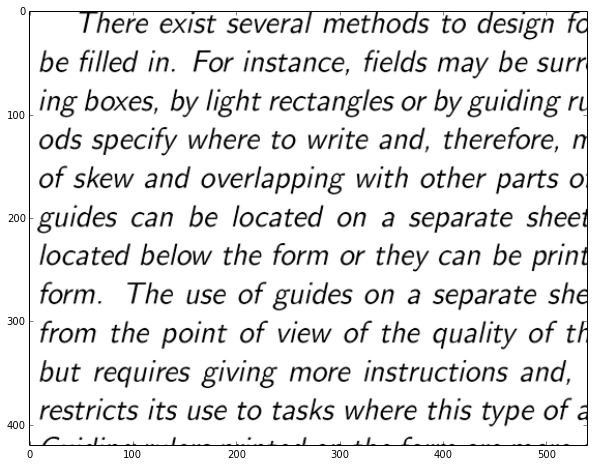

In [159]:
print "Answer image:"
show_image(y_train[img_idx])

Difference between result and right answer:


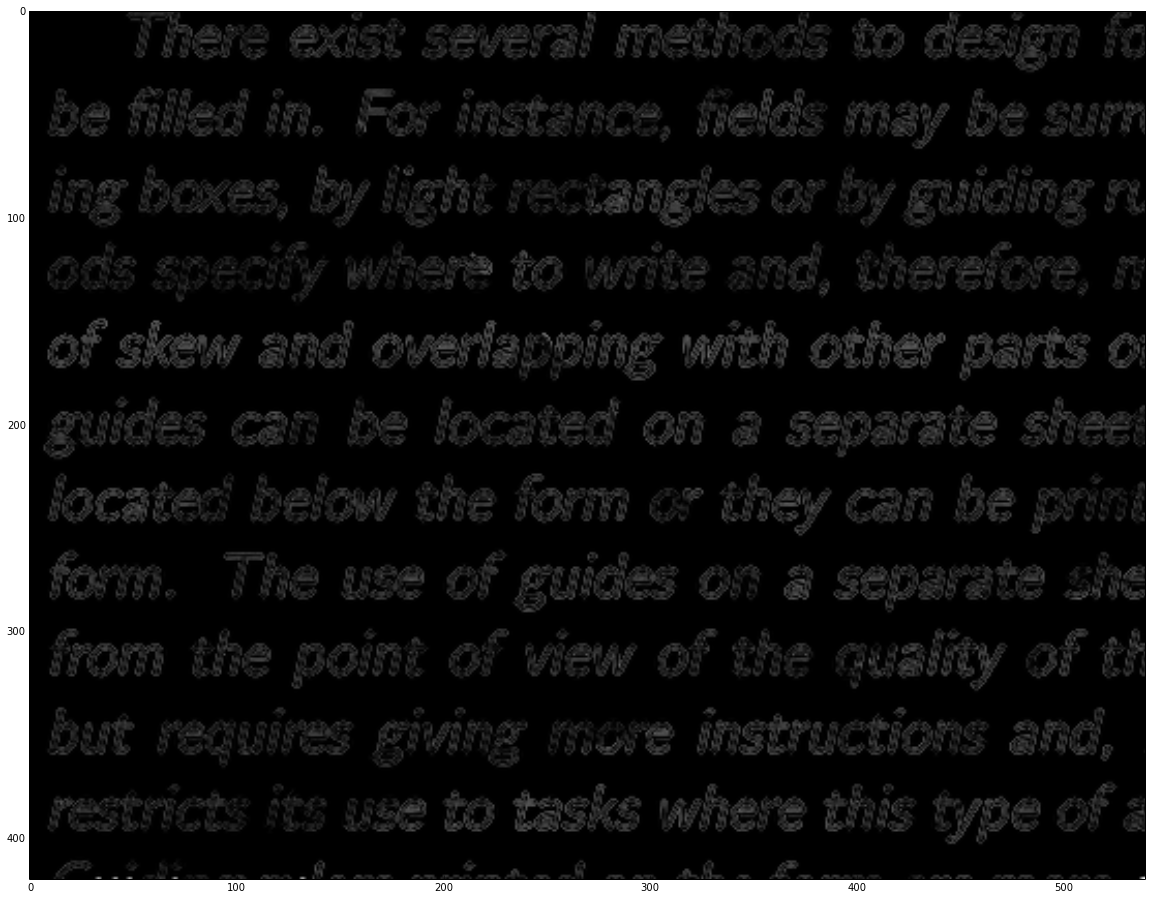

In [160]:
print "Difference between result and right answer:"
show_image(np.abs(blanked - y_train[img_idx]), fig_size=(20, 20))

Картинка выше показывает разность между получившимся результатом и правильным ответом. Видно, что ошибки достигаются **только на самих буквах**. Это значит, что надо "выровнять" оттенки букв. Возможно, это стоит сделать с помощью нейронной сети.

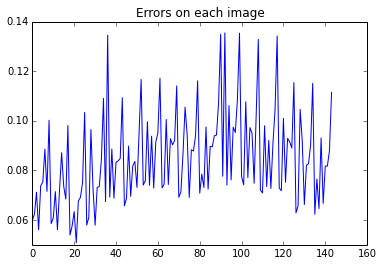

In [173]:
errors = []
for img_idx in xrange(len(X_train)):
    blanked = blank_by_edges_and_fzw(X_train[img_idx], X_train_orig[img_idx])
    #print "error for train image: ", rmse(y_train[img_idx], X_train[img_idx])
    #print "error for train image: ", rmse(y_train[img_idx], blanked)
    #show_image(blanked)
    img_filename = X_train_files[img_idx].split('/')[-1]
    save_image(os.path.join('../output_train_fzw', img_filename), blanked)
    errors.append(rmse(y_train[img_idx], blanked))

plt.title("Errors on each image")
plt.plot(errors)

### Другие методы сегментации

Метод SLIC. Качество и время работы очень зависят от числа итераций max_iter.

In [ ]:
slic = skimage.segmentation.slic(X_train[0], n_segments=100, sigma=0.25, compactness=2, max_iter=10)

slic_max = slic.max()
slic_img = slic / float(slic_max)
show_image(slic_img, fig_size=(20, 20))

Метод работает очень долго, пока не удалось запустить его.

Метод DBSCAN.

In [36]:
@jit
def list_of_nonzero_pos(img):
    nz_img_x, nz_img_y = np.where(X_train[0] != 0)
    nz_list = np.hstack((nz_img_x.reshape(nz_img_x.size, 1),
                         nz_img_y.reshape(nz_img_y.size, 1)))
    return nz_list.astype(float)

train_img_dbs = list_of_nonzero_pos(X_train[0])
train_img_dbs_scl = sklearn.preprocessing.StandardScaler().fit_transform(train_img_dbs)


@jit
def pairwise_dist(X):
    ans = np.empty((X.shape[0], X.shape[0]))
    for i in xrange(len(X)):
        ans[i, i] = 0
        for j in xrange(i + 1, len(X)):
            ans[j, i] = ans[i, j] = sqrt(np.sum((X[i] - X[j]) ** 2))
    return ans

#print train_img_dbs_scl
train_img_pw_dist = pairwise_dist(train_img_dbs_scl[:200])

clr_dbscan = sklearn.cluster.DBSCAN(eps=.5, algorithm='brute',  metric='precomputed')
dbs = clr_dbscan.fit_predict(train_img_pw_dist)
print dbs.shape, np.unique(dbs)

(200,) [0]


Реализация DBSCAN в sklearn имеет следующие недостатки:
* строит (или требует) матрицу попарных расстояний, значит, работает за время O(n^2). При числе пикселей порядка 200'000 это работает очень долго. В лучшей реализации метод работает за O(n logn).
* встроенная функция поиска матрицы попарных расстояний работает параллельно, но захватывает все ядра процессора, поэтому ОС зависает. Пришлось написать свою функцию поиска матрицы попарных расстояний.

In [37]:
# Implementation of DBSCAN from https://pypi.python.org/pypi/ddbscan/.
# Can be downloaded by command 'pip install ddbscan'.
import ddbscan

scan = ddbscan.DDBSCAN(eps=.05, min_pts=5)
@jit
def add_points(points, scan):
    for i in xrange(len(points)):
        scan.add_point(list(points[i]), count=2, desc="")
    return scan

scan = add_points(train_img_dbs_scl[:20], scan)

In [38]:
scan.compute()

Реализация ddbscan из python package index требует точки типа list, а не numpy array, поэтому тоже работает слишком долго.

#### Заметки на будущее

Возможно, лучше использовать Quickshift вместо Felzenswalb. С Quickshift может быть проблема: единственный способ там отсекать компоненты - по размеру, но может быть сложно подобрать порог.

Иногда приведенный способ ухудшает изображение и делает дефекты более заметными, например с картинками с пятнами от кофе:

error for train image:  0.0848314162493
error for train image:  0.1354485893


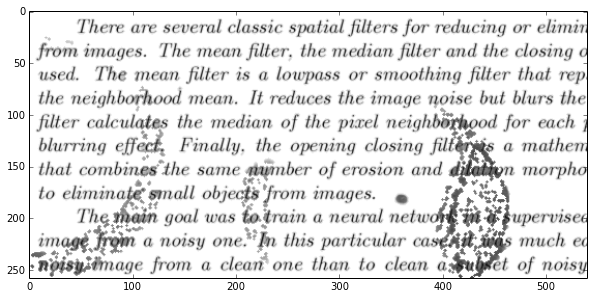

In [175]:
img_idx = 92
blanked = blank_by_edges_and_fzw(X_train[img_idx], X_train_orig[img_idx])
print "error for train image: ", rmse(y_train[img_idx], X_train[img_idx])
print "error for train image: ", rmse(y_train[img_idx], blanked)
show_image(blanked)

Original image:


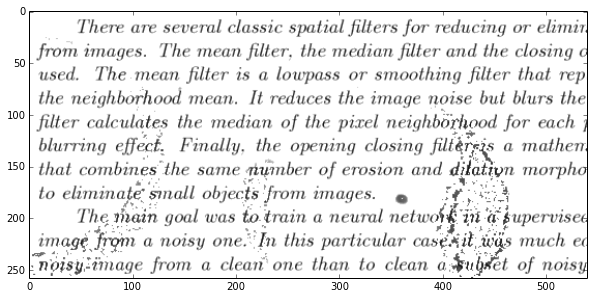

In [165]:
print "Original image:"
show_image(X_train[img_idx])

Здесь дефекты темнее и крупные, а не светлые и мелкие, как на большинстве картинок. Можно попробовать отсекать их не по цвету, а по другим признакам.

В качестве признаков буквы (компоненты) можно будет попробовать gray-level cooccurence matrix, https://en.wikipedia.org/wiki/Co-occurrence_matrix.

Возможно, хороший признак для компонент - максимум distance transform. Он характеризует "толщину".

**Сейчас основные проблемы** такие:

1. неправильные оттенки самих букв . Также выяснил, что в трэйне и в тесте разные оттенки самих букв, как ни странно. Варианты решения проблемы:
 - делать какое-то обучение, чтобы настроиться на нужные цвета 
 - сделать линейное преобразование над изображениями
 - подать изображения сверточной сети, чтобы она подобрала фильтр свертки, который сделает изображения резче и изменит цвета.
2. на многих изображениях способ фильтрации компонент по цвету работает плохо, стоит попробовать 